In [1]:
import tqdm
import pandas as pd
import numpy as np
import neurokit2 as nk

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'''\usepackage{libertine}\usepackage{fontawesome5}\usepackage[dvipsnames]{xcolor}'''
plt.rcParams['ps.usedistiller'] = 'xpdf'
import seaborn as sns
sns.set_theme(style='ticks')

import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_ecg(pid):

    dfECG = pd.read_csv(f"./data/ID{pid}-ECG.csv")
    dfState = pd.read_csv(f"./data/ID{pid}-state.csv")
    dfECG.drop("TimeLsl", axis =1, inplace=True)
    dfECG.loc[dfECG[(dfECG.Time > dfState['Time'][0]) & (dfECG.Time < dfState['Time'][0+1])].index, 'BlockNumber']   = dfState['BlockNumber'][0]
    dfECG.loc[dfECG[(dfECG.Time > dfState['Time'][2]) & (dfECG.Time < dfState['Time'][2+1])].index, 'BlockNumber']   = dfState['BlockNumber'][2]
    dfECG.loc[dfECG[(dfECG.Time > dfState['Time'][4]) & (dfECG.Time < dfState['Time'][4+1])].index, 'BlockNumber']   = dfState['BlockNumber'][4]
    dfECG.loc[dfECG[(dfECG.Time > dfState['Time'][6]) & (dfECG.Time < dfState['Time'][6+1])].index, 'BlockNumber']   = dfState['BlockNumber'][6]
    dfECG.loc[dfECG[(dfECG.Time > dfState['Time'][8]) & (dfECG.Time < dfState['Time'][8+1])].index, 'BlockNumber']  = dfState['BlockNumber'][8]
    dfECG.loc[dfECG[(dfECG.Time > dfState['Time'][10]) & (dfECG.Time < dfState['Time'][10+1])].index, 'BlockNumber'] = dfState['BlockNumber'][10]
    dfECG.loc[dfECG[(dfECG.Time > dfState['Time'][12]) & (dfECG.Time < dfState['Time'][12+1])].index, 'BlockNumber'] = dfState['BlockNumber'][12]
    dfECG = dfECG.dropna()
    dfECG = dfECG.sort_values(by="Time")
    return dfECG

def get_block(df, block_number):
    return df[df.BlockNumber == block_number]

df_all = {}

def extract_ecg_features(pid, df):
    df_features = pd.DataFrame()
    df_current = df

    # # H10 Technical Specification
    # # Sample rate = 130 Hz ± 2 % (Tamb = +20 … +40 °C)
    # #               130 Hz ± 5 % (Tamb = -20 … +70 °C)
    # # https://github.com/polarofficial/polar-ble-sdk/blob/master/technical_documentation/H10_ECG_Explained.docx
    s, _ = nk.ecg_process(df_current['Value'], sampling_rate=130)
    peaks, _ = nk.ecg_peaks(nk.ecg_clean(df_current['Value'], sampling_rate=130),
                            sampling_rate=130,
                            correct_artifacts=True)

    try:
        hrv_rmssd = np.mean(nk.hrv(peaks, sampling_rate=130)['HRV_RMSSD'])
    except Exception:
        hrv_rmssd = np.NaN


    df_features = df_features.append(pd.DataFrame.from_dict([{
        'pid': pid,
        'block_number': df_current['BlockNumber'].iloc[0],
        # https://neuropsychology.github.io/NeuroKit/functions/ecg.html?highlight=ecg_rate
        'ecg_rate_mean': np.mean(s['ECG_Rate']),
        'ecg_rate_var': np.var(s['ECG_Rate']),
        # https://neuropsychology.github.io/NeuroKit/examples/ecg_hrv/ecg_hrv.html?highlight=rmssd
        'hrv_rmssd': hrv_rmssd,
    }]))
    return df_features

In [3]:
pid_valid = list(range(1, 24))
df_all = {}

for pid in tqdm.tqdm(pid_valid):
    if pid == 4 or pid == 8 or pid == 10 or pid == 15 or pid == 16 or pid == 17 or pid == 21:
        continue
    df = load_ecg(pid)
    df_all[pid] = df

100%|██████████| 23/23 [00:02<00:00,  7.95it/s]


In [4]:
df = pd.DataFrame()
for pid in pid_valid:
    print('current pid: ', pid)
    if pid == 4 or pid == 8 or pid == 10 or pid == 15 or pid == 16 or pid == 17 or pid == 21:
        continue
    blocknumbers = df_all[pid].BlockNumber.unique()
    for block_number in blocknumbers:
        df_current = get_block(df_all[pid], block_number)
        df_features = extract_ecg_features(pid, df_current)
        df = df.append(df_features)
df

current pid:  1
current pid:  2
current pid:  3
current pid:  4
current pid:  5
current pid:  6
current pid:  7
current pid:  8
current pid:  9
current pid:  10
current pid:  11
current pid:  12
current pid:  13
current pid:  14
current pid:  15
current pid:  16
current pid:  17
current pid:  18
current pid:  19
current pid:  20
current pid:  21
current pid:  22
current pid:  23


,pid,block_number,ecg_rate_mean,ecg_rate_var,hrv_rmssd
0,1,1.0,95.345525,659.755498,268.963986
0,1,6.0,95.228705,718.533571,288.091628
0,1,4.0,94.828516,760.207311,303.001170
0,1,2.0,94.174818,692.298862,287.803725
0,1,7.0,92.419487,833.728590,331.050488
...,...,...,...,...,...
0,23,4.0,95.306382,890.665676,316.952605
0,23,5.0,93.902097,803.595971,307.356819
0,23,7.0,96.710182,850.241299,297.374839
0,23,2.0,95.077711,905.353914,350.297737


In [5]:
df['ecg_rate_mean_norm'] = (df['ecg_rate_mean'] - df['ecg_rate_mean'].min()) / (df['ecg_rate_mean'].max() - df['ecg_rate_mean'].min())
df['hrv_rmssd_norm'] = (df['hrv_rmssd'] - df['hrv_rmssd'].min()) / (df['hrv_rmssd'].max() - df['hrv_rmssd'].min())

In [6]:
df.to_csv("./processed/ecg_block.csv", index=False)

In [2]:
df = pd.read_csv("./processed/ecg_block.csv")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


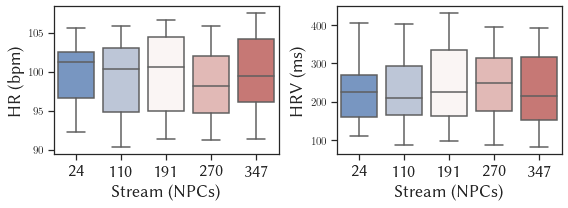

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
colors = sns.color_palette('vlag', n_colors=5)
# colors = ['#d81b60', '#1e88e5', '#ffc107', '#26A08C', '#5945c5']
sns.boxplot(x='block_number', y='ecg_rate_mean', data=df[(df.block_number != 6)&(df.block_number != 7)],  ax=axes[0], palette=colors, showfliers=False, saturation=1)
sns.boxplot(x='block_number', y='hrv_rmssd', data=df[(df.block_number != 6)&(df.block_number != 7)], ax=axes[1], palette=colors, showfliers=False, saturation=1)

axes[0].set_ylabel('HR (bpm)',fontsize=18)
axes[1].set_ylabel('HRV (ms)',fontsize=18)

axes[0].set_xticklabels(['24', '110', '191', '270', '347'], fontsize=18)
axes[1].set_xticklabels(['24', '110', '191', '270', '347'], fontsize=18)


axes[0].legend().set_visible(False)
axes[1].legend().set_visible(False)
handles, labels = axes[1].get_legend_handles_labels()

axes[0].set_xlabel('Stream (NPCs)', fontsize=18)
axes[1].set_xlabel('Stream (NPCs)', fontsize=18)

plt.tight_layout()
plt.savefig('figures/ecg_block.pdf')